Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle

First reload the data we generated in `1_notmnist.ipynb`.

In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 1 to [0.0, 1.0, 0.0 ...], 2 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [4]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

In [6]:
def plot_results(steps, minibatch_loss, minibatch_acc, validation_acc):
    # Plot minibatch loss
    plt.plot(steps, minibatch_loss, 'g-')
    plt.title('Minibatch Loss')
    plt.xlabel('Step')
    plt.ylabel('Minibatch Loss')          
    plt.show()

    # Plot minibatch and aalidation accuracy
    plt.plot(steps, minibatch_acc, 'b-', label='Minibatch Accuracy')
    plt.plot(steps, validation_acc, 'r--', label='Validation Accuracy')
    plt.title('Minibatch and Validation Accuracy')
    plt.xlabel('Step')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')          
    plt.show()

Initialized
Step: 0
  Minibatch loss: 21.665503
  Minibatch accuracy: 7.8%
  Validation accuracy: 9.8%
Step: 1000
  Minibatch loss: 3.273217
  Minibatch accuracy: 75.8%
  Validation accuracy: 75.2%
Step: 2000
  Minibatch loss: 1.905622
  Minibatch accuracy: 79.7%
  Validation accuracy: 77.3%
Step: 3000
  Minibatch loss: 1.589969
  Minibatch accuracy: 78.9%
  Validation accuracy: 79.2%
Test accuracy: 86.7%


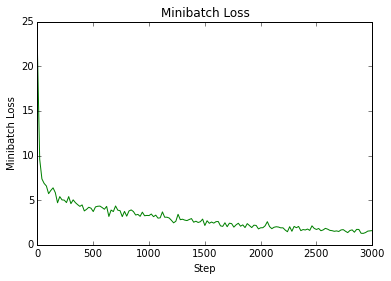

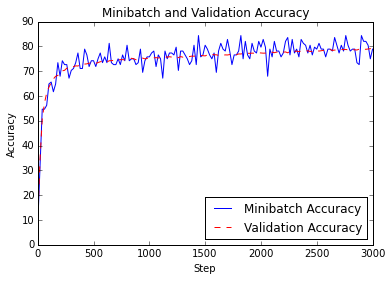

Regularization Test:
Regularization: 0.000100;  Accuracy: 84.710000
Regularization: 0.000126;  Accuracy: 85.000000
Regularization: 0.000158;  Accuracy: 84.730000
Regularization: 0.000200;  Accuracy: 85.480000
Regularization: 0.000251;  Accuracy: 85.300000
Regularization: 0.000316;  Accuracy: 85.380000
Regularization: 0.000398;  Accuracy: 86.010000
Regularization: 0.000501;  Accuracy: 85.590000
Regularization: 0.000631;  Accuracy: 85.970000
Regularization: 0.000794;  Accuracy: 86.390000
Regularization: 0.001000;  Accuracy: 87.360000
Regularization: 0.001259;  Accuracy: 87.770000
Regularization: 0.001585;  Accuracy: 88.020000
Regularization: 0.001995;  Accuracy: 88.530000
Regularization: 0.002512;  Accuracy: 88.800000
Regularization: 0.003162;  Accuracy: 89.140000
Regularization: 0.003981;  Accuracy: 89.530000
Regularization: 0.005012;  Accuracy: 89.450000
Regularization: 0.006310;  Accuracy: 89.310000
Regularization: 0.007943;  Accuracy: 89.160000
Wall time: 1min 45s


In [7]:
batch_size = 128
def train_1(batch_size, num_steps):
    graph = tf.Graph()
    with graph.as_default():

      with tf.name_scope('input'):
        tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
        tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
        tf_valid_dataset = tf.constant(valid_dataset)
        tf_test_dataset = tf.constant(test_dataset)
        beta_regul = tf.placeholder(tf.float32)

      with tf.name_scope('lay_1'): 
        weights = tf.Variable(tf.truncated_normal([image_size * image_size, num_labels]), name='weights')
        biases = tf.Variable(tf.zeros([num_labels]), name='biases')

      logits = tf.matmul(tf_train_dataset, weights) + biases

      with tf.name_scope('loss'):
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels,logits=logits, )) + beta_regul * tf.nn.l2_loss(weights)

      with tf.name_scope('train'):
        train_step = tf.train.GradientDescentOptimizer(0.2).minimize(loss)

      # Predictions for the training, validation, and test data.
      train_prediction = tf.nn.softmax(logits)
      valid_prediction = tf.nn.softmax(tf.matmul(tf_valid_dataset, weights) + biases)
      test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

    with tf.Session(graph=graph) as session:
      tf.global_variables_initializer().run()
      print("Initialized")
      minibatch_loss = []
      minibatch_acc = []
      validation_acc = []
      eval_every = 20
      for step in range(num_steps):    
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)    
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]   
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : 1e-3}
        _, l, predictions = session.run(
          [train_step, loss, train_prediction], feed_dict=feed_dict)
        if (step % eval_every == 0):
          minibatch_loss.append(l) 
          ma = accuracy(predictions, batch_labels)
          minibatch_acc.append(ma)
          va = accuracy(valid_prediction.eval(), valid_labels)
          validation_acc.append(va)
          if (step % 1000 == 0):
            print("Step: %d" % step)
            print("  Minibatch loss: %f" % l)
            print("  Minibatch accuracy: %.1f%%" % ma)
            print("  Validation accuracy: %.1f%%" % va)        
      print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))
      steps = range(0, num_steps, eval_every)
      plot_results(steps, minibatch_loss, minibatch_acc, validation_acc)  
            
    print("Regularization Test:")
    regul_val = [pow(10, i) for i in np.arange(-4, -2, 0.1)]
    for regul in regul_val:
      with tf.Session(graph=graph) as session:
        tf.global_variables_initializer().run()
        for step in range(num_steps):    
          offset = (step * batch_size) % (train_labels.shape[0] - batch_size)  
          batch_data = train_dataset[offset:(offset + batch_size), :]
          batch_labels = train_labels[offset:(offset + batch_size), :] 
          feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : regul}
          _, l, predictions = session.run([train_step, loss, train_prediction], feed_dict=feed_dict)
        acc = accuracy(test_prediction.eval(), test_labels)   
        print("Regularization: %f;  Accuracy: %f" % (regul, acc))   
    
%time train_1(128, 3001)

the 1-layer neural network:
L2 loss for a tensor t using nn.l2_loss(t). 

Initialized
Step: 0
  Minibatch loss: 689.246094
  Minibatch accuracy: 3.9%
  Validation accuracy: 27.8%
Step: 1000
  Minibatch loss: 114.610451
  Minibatch accuracy: 76.6%
  Validation accuracy: 81.1%
Step: 2000
  Minibatch loss: 41.269955
  Minibatch accuracy: 87.5%
  Validation accuracy: 84.9%
Step: 3000
  Minibatch loss: 15.481760
  Minibatch accuracy: 88.3%
  Validation accuracy: 86.8%
Test accuracy: 93.0%


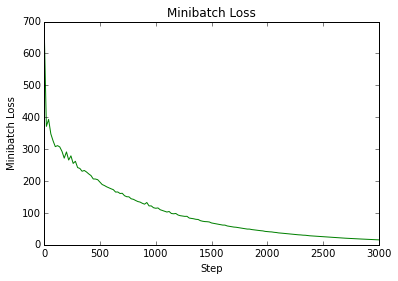

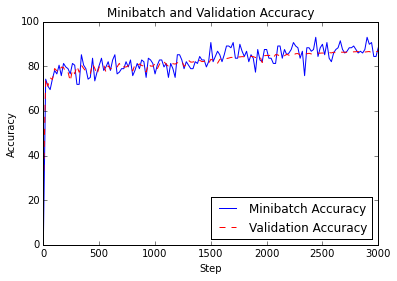

Regularization Test:
Regularization: 0.000100;  Accuracy: 89.760000
Regularization: 0.000126;  Accuracy: 89.670000
Regularization: 0.000158;  Accuracy: 89.630000
Regularization: 0.000200;  Accuracy: 90.050000
Regularization: 0.000251;  Accuracy: 90.520000
Regularization: 0.000316;  Accuracy: 90.480000
Regularization: 0.000398;  Accuracy: 91.140000
Regularization: 0.000501;  Accuracy: 91.510000
Regularization: 0.000631;  Accuracy: 92.140000
Regularization: 0.000794;  Accuracy: 92.780000
Regularization: 0.001000;  Accuracy: 92.900000
Regularization: 0.001259;  Accuracy: 93.500000
Regularization: 0.001585;  Accuracy: 93.260000
Regularization: 0.001995;  Accuracy: 92.950000
Regularization: 0.002512;  Accuracy: 92.700000
Regularization: 0.003162;  Accuracy: 92.580000
Regularization: 0.003981;  Accuracy: 92.080000
Regularization: 0.005012;  Accuracy: 91.760000
Regularization: 0.006310;  Accuracy: 91.280000
Regularization: 0.007943;  Accuracy: 90.840000
Wall time: 40min 29s


In [8]:
def train_1_layer(batch_size, num_hidden_nodes, num_steps):
    graph = tf.Graph()
    with graph.as_default():
        with tf.name_scope('input'): 
            tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
            tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
            tf_valid_dataset = tf.constant(valid_dataset)
            tf_test_dataset = tf.constant(test_dataset)
            beta_regul = tf.placeholder(tf.float32)

        with tf.name_scope('lay_1'): 
            weights1 = tf.Variable(tf.truncated_normal([image_size * image_size, num_hidden_nodes]))
            biases1 = tf.Variable(tf.zeros([num_hidden_nodes]))
            weights2 = tf.Variable(tf.truncated_normal([num_hidden_nodes, num_labels]))
            biases2 = tf.Variable(tf.zeros([num_labels]))

        # Training
        lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
        logits = tf.matmul(lay1_train, weights2) + biases2

        with tf.name_scope('loss'):
            loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) + \
            beta_regul * (tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2))

        with tf.name_scope('train'):
            train_step = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

        # Predictions for the training, validation, and test data.
        train_prediction = tf.nn.softmax(logits)
        lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
        valid_prediction = tf.nn.softmax(tf.matmul(lay1_valid, weights2) + biases2)
        lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
        test_prediction = tf.nn.softmax(tf.matmul(lay1_test, weights2) + biases2)
    
    with tf.Session(graph=graph) as session:
        tf.global_variables_initializer().run()
        print("Initialized")
        minibatch_loss = []
        minibatch_acc = []
        validation_acc = []
        eval_every = 20
        for step in range(num_steps):           
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)           
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]           
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : 1e-3}
            _, l, predictions = session.run([train_step, loss, train_prediction], feed_dict=feed_dict)
            if (step % eval_every == 0):
                minibatch_loss.append(l) 
                ma = accuracy(predictions, batch_labels)
                minibatch_acc.append(ma)
                va = accuracy(valid_prediction.eval(), valid_labels)
                validation_acc.append(va)
                if (step % 1000 == 0):
                    print("Step: %d" % step)
                    print("  Minibatch loss: %f" % l)
                    print("  Minibatch accuracy: %.1f%%" % ma)
                    print("  Validation accuracy: %.1f%%" % va)
        print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))
        steps = range(0, num_steps, eval_every)
        plot_results(steps, minibatch_loss, minibatch_acc, validation_acc)  
    
    print("Regularization Test:")
    regul_val = [pow(10, i) for i in np.arange(-4, -2, 0.1)]   
    for regul in regul_val:    
      with tf.Session(graph=graph) as session:
        tf.global_variables_initializer().run()
        for step in range(num_steps):         
          offset = (step * batch_size) % (train_labels.shape[0] - batch_size)        
          batch_data = train_dataset[offset:(offset + batch_size), :]
          batch_labels = train_labels[offset:(offset + batch_size), :]         
          feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : regul}
          _, l, predictions = session.run([train_step, loss, train_prediction], feed_dict=feed_dict)
        acc = accuracy(test_prediction.eval(), test_labels)       
        print("Regularization: %f;  Accuracy: %f" % (regul, acc))  
        
%time train_1_layer(128, 1024, 3001)    

---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

Initialized
Step: 0
  Minibatch loss: 316.781067
  Minibatch accuracy: 10.2%
  Validation accuracy: 30.1%
Step: 20
  Minibatch loss: 0.000000
  Minibatch accuracy: 100.0%
  Validation accuracy: 61.9%
Step: 40
  Minibatch loss: 0.000000
  Minibatch accuracy: 100.0%
  Validation accuracy: 61.9%
Step: 60
  Minibatch loss: 0.000000
  Minibatch accuracy: 100.0%
  Validation accuracy: 61.9%
Step: 80
  Minibatch loss: 0.000000
  Minibatch accuracy: 100.0%
  Validation accuracy: 61.9%
Step: 100
  Minibatch loss: 0.000000
  Minibatch accuracy: 100.0%
  Validation accuracy: 61.9%
Test accuracy: 67.4%


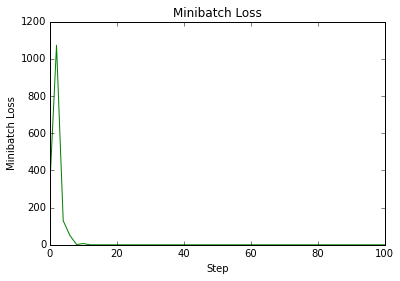

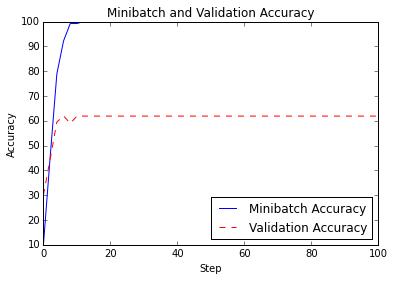

Wall time: 35.4 s


In [9]:
def train_overfiting_model(batch_size, num_hidden_nodes, num_steps, num_bacthes) :     
    graph = tf.Graph()
    with graph.as_default():
        with tf.name_scope('input'):
            tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
            tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
            tf_valid_dataset = tf.constant(valid_dataset)
            tf_test_dataset = tf.constant(test_dataset)
            beta_regul = tf.placeholder(tf.float32)

        with tf.name_scope('lay_1'): 
            weights1 = tf.Variable(tf.truncated_normal([image_size * image_size, num_hidden_nodes]))
            biases1 = tf.Variable(tf.zeros([num_hidden_nodes]))
            weights2 = tf.Variable(tf.truncated_normal([num_hidden_nodes, num_labels]))
            biases2 = tf.Variable(tf.zeros([num_labels]))

        # Training
        lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
        logits = tf.matmul(lay1_train, weights2) + biases2

        with tf.name_scope('loss'):
            loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels))
            tf.summary.scalar('loss', loss)

        with tf.name_scope('train'):
            train_step = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

        # Predictions for the training, validation, and test data.
        train_prediction = tf.nn.softmax(logits)
        lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
        valid_prediction = tf.nn.softmax(tf.matmul(lay1_valid, weights2) + biases2)
        lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
        test_prediction = tf.nn.softmax(tf.matmul(lay1_test, weights2) + biases2)

    with tf.Session(graph=graph) as session:
        tf.global_variables_initializer().run()
        print("Initialized")
        minibatch_loss = []
        minibatch_acc = []
        validation_acc = []
        eval_every = 2
        for step in range(num_steps):           
            offset = step % num_bacthes           
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]           
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : 1e-3}
            _, l, predictions = session.run([train_step, loss, train_prediction], feed_dict=feed_dict)
            if (step % eval_every == 0):
                minibatch_loss.append(l) 
                ma = accuracy(predictions, batch_labels)
                minibatch_acc.append(ma)
                va = accuracy(valid_prediction.eval(), valid_labels)
                validation_acc.append(va)
                if (step % 20 == 0):
                    print("Step: %d" % step)
                    print("  Minibatch loss: %f" % l)
                    print("  Minibatch accuracy: %.1f%%" % ma)
                    print("  Validation accuracy: %.1f%%" % va)
        print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))  
        steps = range(0, num_steps, eval_every)
        plot_results(steps, minibatch_loss, minibatch_acc, validation_acc)  
        
%time train_overfiting_model(128, 1024, 101, 3)

---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

Initialized
Step: 0
  Minibatch loss: 457.054932
  Minibatch accuracy: 10.2%
  Validation accuracy: 37.2%
Step: 20
  Minibatch loss: 4.105723
  Minibatch accuracy: 98.4%
  Validation accuracy: 65.5%
Step: 40
  Minibatch loss: 3.286811
  Minibatch accuracy: 98.4%
  Validation accuracy: 67.9%
Step: 60
  Minibatch loss: 0.000000
  Minibatch accuracy: 100.0%
  Validation accuracy: 68.9%
Step: 80
  Minibatch loss: 0.571933
  Minibatch accuracy: 98.4%
  Validation accuracy: 69.0%
Step: 100
  Minibatch loss: 0.000000
  Minibatch accuracy: 100.0%
  Validation accuracy: 69.5%
Test accuracy: 76.1%


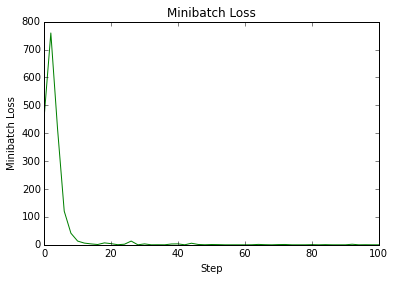

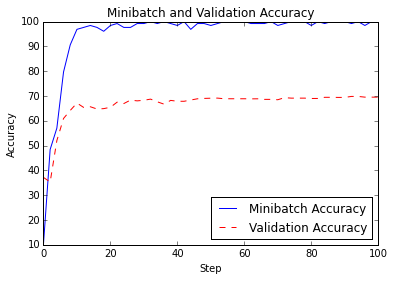

Wall time: 35.3 s


In [10]:
def train_dropout_model(batch_size, num_hidden_nodes, num_steps, num_batches):  
    graph = tf.Graph()
    with graph.as_default():
        with tf.name_scope('input'): 
            tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
            tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
            tf_valid_dataset = tf.constant(valid_dataset)
            tf_test_dataset = tf.constant(test_dataset)

        with tf.name_scope('lay_1'): 
            weights1 = tf.Variable(tf.truncated_normal([image_size * image_size, num_hidden_nodes]))
            biases1 = tf.Variable(tf.zeros([num_hidden_nodes]))
            weights2 = tf.Variable(tf.truncated_normal([num_hidden_nodes, num_labels]))
            biases2 = tf.Variable(tf.zeros([num_labels]))

        # Training computation.
        lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
        drop1 = tf.nn.dropout(lay1_train, 0.5)
        logits = tf.matmul(drop1, weights2) + biases2
        
        with tf.name_scope('loss'):        
            loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))

        with tf.name_scope('train'):
            train_step = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

        # Predictions for the training, validation, and test data.
        train_prediction = tf.nn.softmax(logits)
        lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
        valid_prediction = tf.nn.softmax(tf.matmul(lay1_valid, weights2) + biases2)
        lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
        test_prediction = tf.nn.softmax(tf.matmul(lay1_test, weights2) + biases2)

    with tf.Session(graph=graph) as session:
        tf.global_variables_initializer().run()
        print("Initialized")
        minibatch_loss = []
        minibatch_acc = []
        validation_acc = []
        eval_every = 2
        for step in range(num_steps):           
            offset = step % num_batches           
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]           
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
            _, l, predictions = session.run(
              [train_step, loss, train_prediction], feed_dict=feed_dict)
            if (step % eval_every == 0):
                minibatch_loss.append(l) 
                ma = accuracy(predictions, batch_labels)
                minibatch_acc.append(ma)
                va = accuracy(valid_prediction.eval(), valid_labels)
                validation_acc.append(va)
                if (step % 20 == 0):
                    print("Step: %d" % step)
                    print("  Minibatch loss: %f" % l)
                    print("  Minibatch accuracy: %.1f%%" % ma)
                    print("  Validation accuracy: %.1f%%" % va)
        print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))
        steps = range(0, num_steps, eval_every)
        plot_results(steps, minibatch_loss, minibatch_acc, validation_acc) 
        
%time train_dropout_model(128, 1024, 101, 3)

---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---


Initialized
Step: 0
  Minibatch loss: 5.019742
  Minibatch accuracy: 10.2%
  Validation accuracy: 31.2%
Step: 1000
  Minibatch loss: 0.779673
  Minibatch accuracy: 84.4%
  Validation accuracy: 85.5%
Step: 2000
  Minibatch loss: 0.470950
  Minibatch accuracy: 93.0%
  Validation accuracy: 86.8%
Step: 3000
  Minibatch loss: 0.560855
  Minibatch accuracy: 88.3%
  Validation accuracy: 87.1%
Step: 4000
  Minibatch loss: 0.470987
  Minibatch accuracy: 90.6%
  Validation accuracy: 87.7%
Step: 5000
  Minibatch loss: 0.529497
  Minibatch accuracy: 89.1%
  Validation accuracy: 88.3%
Step: 6000
  Minibatch loss: 0.617268
  Minibatch accuracy: 85.9%
  Validation accuracy: 88.3%
Step: 7000
  Minibatch loss: 0.565702
  Minibatch accuracy: 87.5%
  Validation accuracy: 88.5%
Step: 8000
  Minibatch loss: 0.692198
  Minibatch accuracy: 82.0%
  Validation accuracy: 88.7%
Step: 9000
  Minibatch loss: 0.562963
  Minibatch accuracy: 89.8%
  Validation accuracy: 88.7%
Step: 10000
  Minibatch loss: 0.498991
  

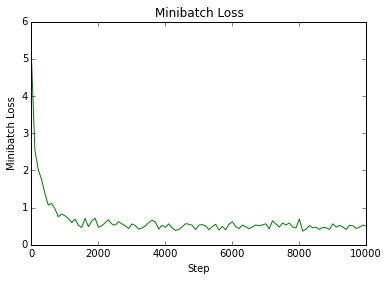

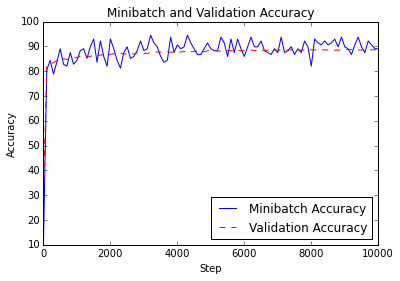

Wall time: 6min 56s


In [11]:
def train_2_hidden_layers_model(batch_size, num_hidden_nodes1, num_hidden_nodes2, beta_regul, num_steps): 
    graph = tf.Graph()
    with graph.as_default():
        with tf.name_scope('input'): 
            tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
            tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
            tf_valid_dataset = tf.constant(valid_dataset)
            tf_test_dataset = tf.constant(test_dataset)
            global_step = tf.Variable(0)

        with tf.name_scope('layers'):
            with tf.name_scope('weights1'):
                weights1 = tf.Variable(tf.truncated_normal([image_size * image_size, num_hidden_nodes1], stddev=np.sqrt(2.0 / (image_size * image_size))))
            with tf.name_scope('biases1'): 
                biases1 = tf.Variable(tf.zeros([num_hidden_nodes1]))
            with tf.name_scope('weights2'):
                weights2 = tf.Variable(tf.truncated_normal([num_hidden_nodes1, num_hidden_nodes2], stddev=np.sqrt(2.0 / num_hidden_nodes1)))
            with tf.name_scope('biases2'):                 
                biases2 = tf.Variable(tf.zeros([num_hidden_nodes2]))
            with tf.name_scope('weights3'):                
                weights3 = tf.Variable(tf.truncated_normal([num_hidden_nodes2, num_labels], stddev=np.sqrt(2.0 / num_hidden_nodes2)))
            with tf.name_scope('biases2'): 
                biases3 = tf.Variable(tf.zeros([num_labels]))

        # Training computation.
        lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
        lay2_train = tf.nn.relu(tf.matmul(lay1_train, weights2) + biases2)
        logits = tf.matmul(lay2_train, weights3) + biases3
        with tf.name_scope('loss'):
            loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels)) + \
              beta_regul * (tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2) + tf.nn.l2_loss(weights3))
            tf.summary.scalar('loss', loss)

        with tf.name_scope('train'):
            learning_rate = tf.train.exponential_decay(0.5, global_step, 1000, 0.65, staircase=True)
            train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

        # Predictions for the training, validation, and test data.
        train_prediction = tf.nn.softmax(logits)
        lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
        lay2_valid = tf.nn.relu(tf.matmul(lay1_valid, weights2) + biases2)
        valid_prediction = tf.nn.softmax(tf.matmul(lay2_valid, weights3) + biases3)
        lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
        lay2_test = tf.nn.relu(tf.matmul(lay1_test, weights2) + biases2)
        test_prediction = tf.nn.softmax(tf.matmul(lay2_test, weights3) + biases3)

    with tf.Session(graph=graph) as session:
        tf.global_variables_initializer().run()
        print("Initialized")
        minibatch_loss = []
        minibatch_acc = []
        validation_acc = []
        eval_every = 100
        for step in range(num_steps):           
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)           
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]         
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
            _, l, predictions = session.run(
              [train_step, loss, train_prediction], feed_dict=feed_dict)
            if (step % eval_every == 0):
                minibatch_loss.append(l) 
                ma = accuracy(predictions, batch_labels)
                minibatch_acc.append(ma)
                va = accuracy(valid_prediction.eval(), valid_labels)
                validation_acc.append(va)
                if (step % 1000 == 0):
                    print("Step: %d" % step)
                    print("  Minibatch loss: %f" % l)
                    print("  Minibatch accuracy: %.1f%%" % ma)
                    print("  Validation accuracy: %.1f%%" % va)
        print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))
        steps = range(0, num_steps, eval_every)
        plot_results(steps, minibatch_loss, minibatch_acc, validation_acc) 
        
%time train_2_hidden_layers_model(128, 1024, 100, 0.003, 10001)

In [12]:
def train_3_hidden_layers_model(batch_size, num_hidden_nodes1, num_hidden_nodes2, num_hidden_nodes3, keep_prob, num_steps, decay_steps, decay_rate): 
    graph = tf.Graph()
    with graph.as_default():
        with tf.name_scope('input'):    
            tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
            tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
            tf_valid_dataset = tf.constant(valid_dataset)
            tf_test_dataset = tf.constant(test_dataset)
            global_step = tf.Variable(0)
        with tf.name_scope('layer'):
            with tf.name_scope('weights1'):
                weights1 = tf.Variable(tf.truncated_normal([image_size * image_size, num_hidden_nodes1], stddev=np.sqrt(2.0 / (image_size * image_size))))
            with tf.name_scope('biases1'):                
                biases1 = tf.Variable(tf.zeros([num_hidden_nodes1]))
            with tf.name_scope('weights2'):    
                weights2 = tf.Variable(tf.truncated_normal([num_hidden_nodes1, num_hidden_nodes2], stddev=np.sqrt(2.0 / num_hidden_nodes1)))
            with tf.name_scope('biases2'):  
                biases2 = tf.Variable(tf.zeros([num_hidden_nodes2]))
            with tf.name_scope('weights3'):            
                weights3 = tf.Variable(tf.truncated_normal([num_hidden_nodes2, num_hidden_nodes3], stddev=np.sqrt(2.0 / num_hidden_nodes2)))
            with tf.name_scope('biases3'):  
                biases3 = tf.Variable(tf.zeros([num_hidden_nodes3]))
            with tf.name_scope('weights4'):            
                weights4 = tf.Variable(tf.truncated_normal([num_hidden_nodes3, num_labels], stddev=np.sqrt(2.0 / num_hidden_nodes3)))
            with tf.name_scope('biases4'):                 
                biases4 = tf.Variable(tf.zeros([num_labels]))
          
            lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
            lay2_train = tf.nn.relu(tf.matmul(lay1_train, weights2) + biases2)
            lay3_train = tf.nn.relu(tf.matmul(lay2_train, weights3) + biases3)
            
        logits = tf.matmul(lay3_train, weights4) + biases4
        with tf.name_scope('loss'):
            loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels))
            tf.summary.scalar('loss', loss)

        with tf.name_scope('train'):
            learning_rate = tf.train.exponential_decay(0.5, global_step, decay_steps, decay_rate, staircase=True)
            optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

        # Predictions for the training, validation, and test data.
        train_prediction = tf.nn.softmax(logits)
        lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
        lay2_valid = tf.nn.relu(tf.matmul(lay1_valid, weights2) + biases2)
        lay3_valid = tf.nn.relu(tf.matmul(lay2_valid, weights3) + biases3)
        valid_prediction = tf.nn.softmax(tf.matmul(lay3_valid, weights4) + biases4)
        
        lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
        lay2_test = tf.nn.relu(tf.matmul(lay1_test, weights2) + biases2)
        lay3_test = tf.nn.relu(tf.matmul(lay2_test, weights3) + biases3)
        test_prediction = tf.nn.softmax(tf.matmul(lay3_test, weights4) + biases4)
    
    with tf.Session(graph=graph) as session:
        tf.global_variables_initializer().run()
        print("Initialized")
        minibatch_loss = []
        minibatch_acc = []
        validation_acc = []
        eval_every = 100
        for step in range(num_steps):           
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)           
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]          
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
            if (step % eval_every == 0):
                minibatch_loss.append(l) 
                ma = accuracy(predictions, batch_labels)
                minibatch_acc.append(ma)
                va = accuracy(valid_prediction.eval(), valid_labels)
                validation_acc.append(va)
                if (step % 2000 == 0):
                    print("Step: %d" % step)
                    print("  Minibatch loss: %f" % l)
                    print("  Minibatch accuracy: %.1f%%" % ma)
                    print("  Validation accuracy: %.1f%%" % va)
        print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))
        steps = range(0, num_steps, eval_every)
        plot_results(steps, minibatch_loss, minibatch_acc, validation_acc)

Initialized
Step: 0
  Minibatch loss: 2.379574
  Minibatch accuracy: 8.6%
  Validation accuracy: 31.2%
Step: 2000
  Minibatch loss: 0.260746
  Minibatch accuracy: 95.3%
  Validation accuracy: 88.4%
Step: 4000
  Minibatch loss: 0.278899
  Minibatch accuracy: 91.4%
  Validation accuracy: 89.5%
Step: 6000
  Minibatch loss: 0.381628
  Minibatch accuracy: 89.1%
  Validation accuracy: 90.1%
Step: 8000
  Minibatch loss: 0.307846
  Minibatch accuracy: 89.8%
  Validation accuracy: 90.2%
Step: 10000
  Minibatch loss: 0.148622
  Minibatch accuracy: 96.1%
  Validation accuracy: 90.2%
Step: 12000
  Minibatch loss: 0.128665
  Minibatch accuracy: 95.3%
  Validation accuracy: 90.3%
Step: 14000
  Minibatch loss: 0.112709
  Minibatch accuracy: 96.9%
  Validation accuracy: 90.9%
Step: 16000
  Minibatch loss: 0.027481
  Minibatch accuracy: 99.2%
  Validation accuracy: 90.9%
Step: 18000
  Minibatch loss: 0.037895
  Minibatch accuracy: 100.0%
  Validation accuracy: 91.1%
Step: 20000
  Minibatch loss: 0.0856

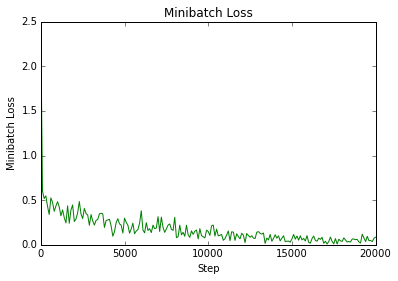

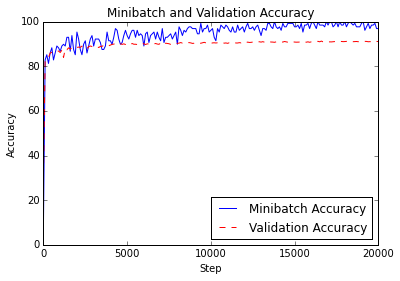

Wall time: 13min 42s


In [13]:
%time train_3_hidden_layers_model(128, 1024, 256, 128, 0.5, 20001, 4000, 0.6) 

Initialized
Step: 0
  Minibatch loss: 2.346694
  Minibatch accuracy: 10.9%
  Validation accuracy: 36.6%
Step: 2000
  Minibatch loss: 0.257972
  Minibatch accuracy: 93.0%
  Validation accuracy: 88.7%
Step: 4000
  Minibatch loss: 0.243376
  Minibatch accuracy: 92.2%
  Validation accuracy: 89.4%
Step: 6000
  Minibatch loss: 0.372111
  Minibatch accuracy: 89.8%
  Validation accuracy: 89.7%
Step: 8000
  Minibatch loss: 0.272303
  Minibatch accuracy: 90.6%
  Validation accuracy: 89.7%
Step: 10000
  Minibatch loss: 0.166094
  Minibatch accuracy: 93.0%
  Validation accuracy: 90.0%
Step: 12000
  Minibatch loss: 0.125077
  Minibatch accuracy: 96.1%
  Validation accuracy: 90.1%
Step: 14000
  Minibatch loss: 0.111949
  Minibatch accuracy: 96.1%
  Validation accuracy: 90.6%
Step: 16000
  Minibatch loss: 0.018314
  Minibatch accuracy: 100.0%
  Validation accuracy: 90.6%
Step: 18000
  Minibatch loss: 0.040374
  Minibatch accuracy: 100.0%
  Validation accuracy: 90.7%
Step: 20000
  Minibatch loss: 0.03

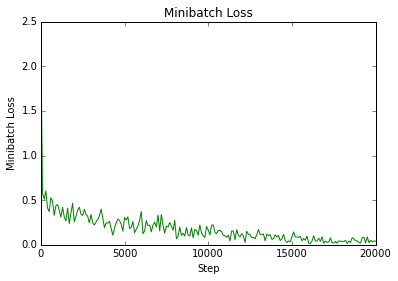

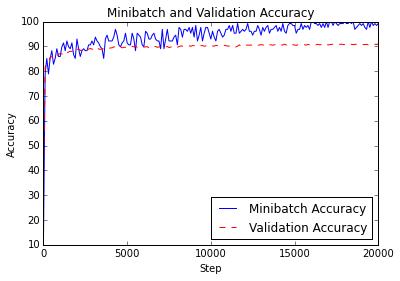

Wall time: 21min 47s


In [14]:
%time train_3_hidden_layers_model(128, 1024, 256, 128, 0.5, 20001, 4000, 0.7) 

In [17]:
def train_4_hidden_layers_model(batch_size, num_hidden_nodes1, num_hidden_nodes2, num_hidden_nodes3, num_hidden_nodes4, keep_prob, num_steps, decay_steps, decay_rate): 
    graph = tf.Graph()
    with graph.as_default():
        with tf.name_scope('input'): 
            tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
            tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
            tf_valid_dataset = tf.constant(valid_dataset)
            tf_test_dataset = tf.constant(test_dataset)
            global_step = tf.Variable(0)

        with tf.name_scope('4_layers'):
            weights1 = tf.Variable(tf.truncated_normal([image_size * image_size, num_hidden_nodes1], stddev=np.sqrt(2.0 / (image_size * image_size))))
            biases1 = tf.Variable(tf.zeros([num_hidden_nodes1]))
            weights2 = tf.Variable(tf.truncated_normal([num_hidden_nodes1, num_hidden_nodes2], stddev=np.sqrt(2.0 / num_hidden_nodes1)))
            biases2 = tf.Variable(tf.zeros([num_hidden_nodes2]))
            weights3 = tf.Variable(tf.truncated_normal([num_hidden_nodes2, num_hidden_nodes3], stddev=np.sqrt(2.0 / num_hidden_nodes2)))
            biases3 = tf.Variable(tf.zeros([num_hidden_nodes3]))
            weights4 = tf.Variable(tf.truncated_normal([num_hidden_nodes3, num_hidden_nodes4], stddev=np.sqrt(2.0 / num_hidden_nodes3)))
            biases4 = tf.Variable(tf.zeros([num_hidden_nodes4]))
            weights5 = tf.Variable(tf.truncated_normal([num_hidden_nodes4, num_labels], stddev=np.sqrt(2.0 / num_hidden_nodes4)))
            biases5 = tf.Variable(tf.zeros([num_labels]))
    
            # Training computation.
            lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
            drop1 = tf.nn.dropout(lay1_train, 0.5)
            lay2_train = tf.nn.relu(tf.matmul(drop1, weights2) + biases2)
            drop2 = tf.nn.dropout(lay2_train, 0.5)
            lay3_train = tf.nn.relu(tf.matmul(drop2, weights3) + biases3)
            drop3 = tf.nn.dropout(lay3_train, 0.5)        
            lay4_train = tf.nn.relu(tf.matmul(drop3, weights4) + biases4)
            drop4 = tf.nn.dropout(lay4_train, 0.5)
        
        logits = tf.matmul(drop4, weights5) + biases5

        with tf.name_scope('loss'):
            loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels))
            tf.summary.scalar('loss', loss)
            
        with tf.name_scope('train'):
            learning_rate = tf.train.exponential_decay(0.5, global_step, decay_steps, decay_rate, staircase=True)
            optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
  
        # Predictions for the training, validation, and test data.
        train_prediction = tf.nn.softmax(logits)
        lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
        lay2_valid = tf.nn.relu(tf.matmul(lay1_valid, weights2) + biases2)
        lay3_valid = tf.nn.relu(tf.matmul(lay2_valid, weights3) + biases3)
        lay4_valid = tf.nn.relu(tf.matmul(lay3_valid, weights4) + biases4)
        valid_prediction = tf.nn.softmax(tf.matmul(lay4_valid, weights5) + biases5)
        lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
        lay2_test = tf.nn.relu(tf.matmul(lay1_test, weights2) + biases2)
        lay3_test = tf.nn.relu(tf.matmul(lay2_test, weights3) + biases3)
        lay4_test = tf.nn.relu(tf.matmul(lay3_test, weights4) + biases4)
        test_prediction = tf.nn.softmax(tf.matmul(lay4_test, weights5) + biases5)
     
    with tf.Session(graph=graph) as session:        
        tf.global_variables_initializer().run()
        print("Initialized")
        minibatch_loss = []
        minibatch_acc = []
        validation_acc = []
        eval_every = 100
        for step in range(num_steps):            
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)           
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]           
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
            _, l, predictions = session.run(
              [optimizer, loss, train_prediction], feed_dict=feed_dict)
            if (step % eval_every == 0):
                minibatch_loss.append(l) 
                ma = accuracy(predictions, batch_labels)
                minibatch_acc.append(ma)
                va = accuracy(valid_prediction.eval(), valid_labels)
                validation_acc.append(va)
                if (step % 2000 == 0):
                    print("Step: %d" % step)
                    print("  Minibatch loss: %f" % l)
                    print("  Minibatch accuracy: %.1f%%" % ma)
                    print("  Validation accuracy: %.1f%%" % va)
        print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))  
        steps = range(0, num_steps, eval_every)
        plot_results(steps, minibatch_loss, minibatch_acc, validation_acc)

Initialized
Step: 0
  Minibatch loss: 3.085863
  Minibatch accuracy: 10.9%
  Validation accuracy: 14.2%
Step: 2000
  Minibatch loss: 0.462683
  Minibatch accuracy: 89.1%
  Validation accuracy: 85.3%
Step: 4000
  Minibatch loss: 0.385787
  Minibatch accuracy: 88.3%
  Validation accuracy: 86.7%
Step: 6000
  Minibatch loss: 0.493143
  Minibatch accuracy: 84.4%
  Validation accuracy: 87.8%
Step: 8000
  Minibatch loss: 0.645048
  Minibatch accuracy: 80.5%
  Validation accuracy: 88.1%
Step: 10000
  Minibatch loss: 0.442259
  Minibatch accuracy: 85.2%
  Validation accuracy: 88.7%
Step: 12000
  Minibatch loss: 0.517472
  Minibatch accuracy: 85.2%
  Validation accuracy: 88.8%
Step: 14000
  Minibatch loss: 0.452545
  Minibatch accuracy: 86.7%
  Validation accuracy: 89.1%
Step: 16000
  Minibatch loss: 0.309084
  Minibatch accuracy: 90.6%
  Validation accuracy: 89.2%
Step: 18000
  Minibatch loss: 0.254982
  Minibatch accuracy: 93.8%
  Validation accuracy: 89.6%
Step: 20000
  Minibatch loss: 0.4754

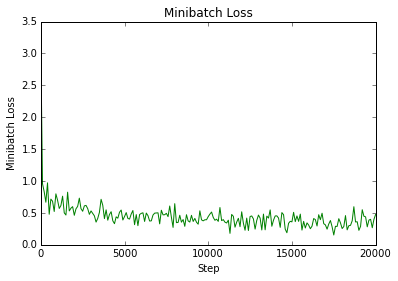

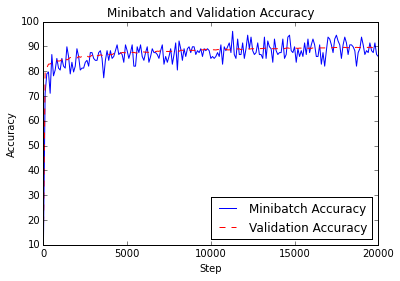

Wall time: 24min 3s


In [18]:
%time train_4_hidden_layers_model(128, 1024, 512, 256, 256, 0.5, 20001, 4000, 0.65) 

In [ ]:
%time train_4_hidden_layers_model(128, 1024, 512, 256, 256, 0.5, 20001, 5000, 0.80) 

Initialized
Step: 0